# Predict DO

Predict DO and variedades just with the type of wine and the estilo

In [1]:
import pandas as pd
#from pandasgui import show
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import random
import seaborn as sns
sns.set_style('whitegrid')
import re
import pickle
from tqdm import tqdm

In [2]:
import tensorflow as tf
# Check if tensorflow has been imported correclty and it's running through the GPU
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# Data handling
from sklearn.model_selection import train_test_split

# Random Forest
from sklearn.ensemble import RandomForestClassifier

# CatBoost
from catboost import CatBoostClassifier

# Autogluon
from autogluon.tabular import TabularDataset, TabularPredictor

# NN
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping


## Load the data

Let's start predicting the DO

In [4]:
X_ITEMS_PATH = r"../EDA/X_pred_do_variedad.csv"
Y_ITEMS_PATH = r"../EDA/y_pred_do.csv"

X = pd.read_csv(X_ITEMS_PATH)
y = pd.read_csv(Y_ITEMS_PATH)

This is our feature vector that contains *type simplified* and *style*(based on the original style plus *boca*):

In [5]:
X.columns

Index(['blanco', 'tinto', 'espumoso', 'rosado', 'corpulento', 'sabroso',
       'frutal', 'equilibrado', 'cítrico', 'especiado', 'suave', 'herbal',
       'persistente', 'floral', 'fresco', 'tostado', 'correcto', 'amargo',
       'aromático', 'dulce', 'notas de levadura', 'oxidado', 'silvestre',
       'balsámico', 'con defectos', 'taninos', 'elegante', 'con vejez',
       'cálido', 'mineral', 'tropical', 'varietal', 'clásico', 'carnoso',
       'cremoso', 'rústico'],
      dtype='object')

In [6]:
X.shape,y.shape

((2526, 36), (2526, 12))

## Split the data into train and test

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.85, random_state=0)

print("X")
print(X_train.shape)
print(X_test.shape)

print("Y")
print(y_train.shape)
print(y_test.shape)

X
(2147, 36)
(379, 36)
Y
(2147, 12)
(379, 12)


## RandomForest

### Default Implementation

Random Forest is one of the most used and navie algorithm. It's always a good starting point

In [37]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train.idxmax(axis=1))
clf.score(X_test,y_test.idxmax(axis=1))

0.48284960422163586

We see that we get 47% of the times correct, thats a good starting result as the baseline would be 8% as there are 12 possible choices:

#### Classical Confusion Matrix

Let's draw the confusion matrix to check if our **predictor is biased** agianst a particular class

In [38]:
def create_confusion_matrix(clf,X_val,y_val,title,**kwargs):
    
    if "model" in kwargs.keys():

        y_pred_val = clf.predict(X_val,model=kwargs["model"])
    else:
        y_pred_val = clf.predict(X_val)
    
    cm = confusion_matrix(y_val.idxmax(axis=1), y_pred_val,labels=y_val.columns,normalize="pred") * 100
    sns.heatmap(cm, annot=True, fmt='.1f',annot_kws={'size':10},
                cmap=plt.cm.Greens, linewidths=0.2,vmin=0,vmax=100,cbar_kws={'format': '%.f%%', 'ticks': [0, 100]},)

    tick_marks = np.arange(len(y_val.columns)) +.5
    plt.xticks(tick_marks,y_val.columns,rotation=90)
    plt.yticks(tick_marks,y_val.columns,rotation=0)

    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(title);

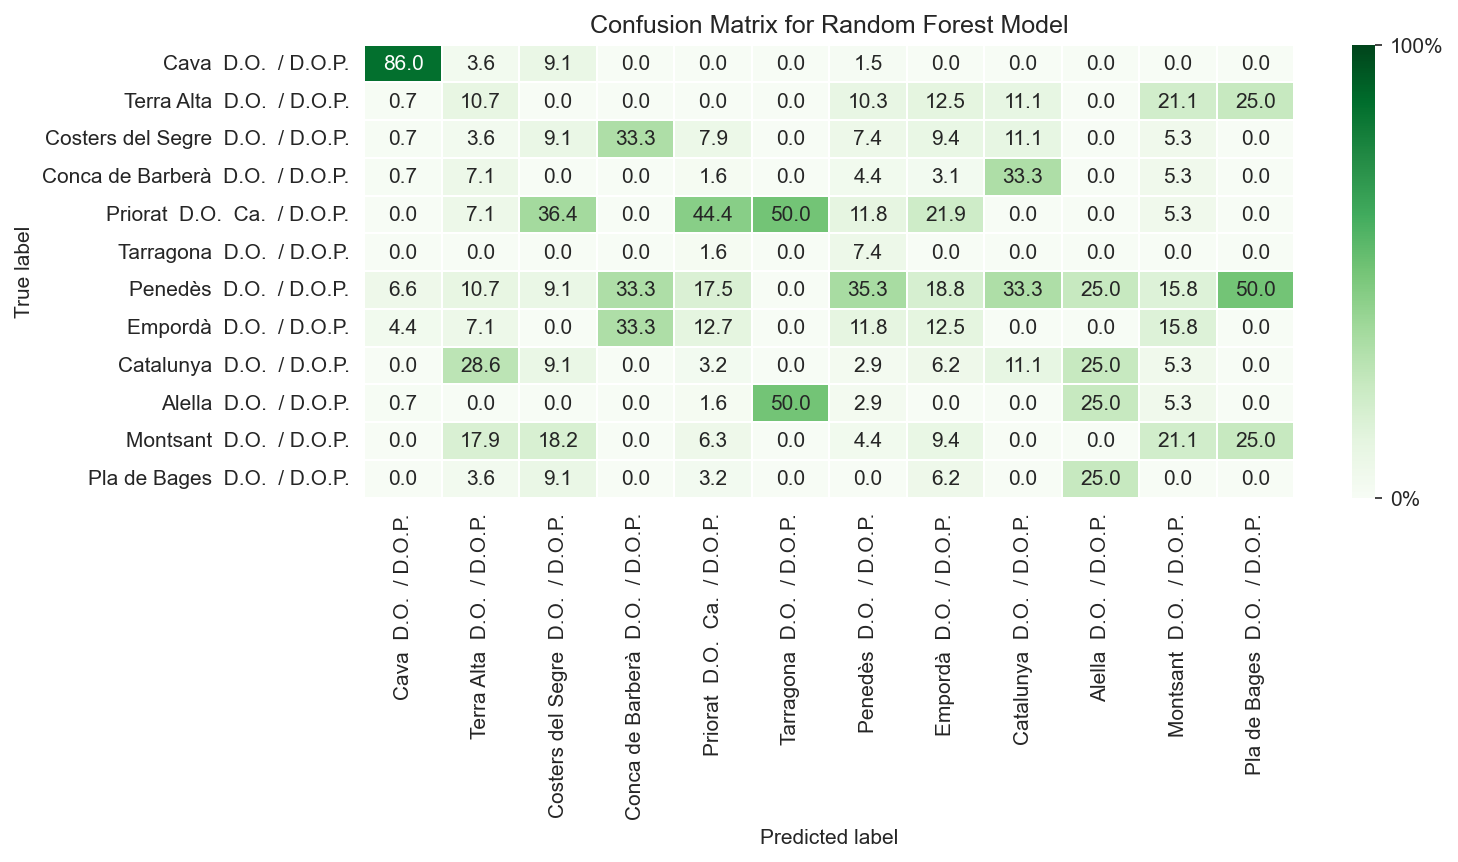

In [39]:
plt.figure(figsize=(10,4),dpi=150);
create_confusion_matrix(clf,X_test,y_test,title='Confusion Matrix for Random Forest Model')


We can see that our Random Forest predictor is really biased against the Cava DO and is clearly underperforming in all te others DO. This made us reallized that our **data is clearly unbalanced as eventhough we have 10 different DO, 34%** of the samples corresponds to the Cava DO:

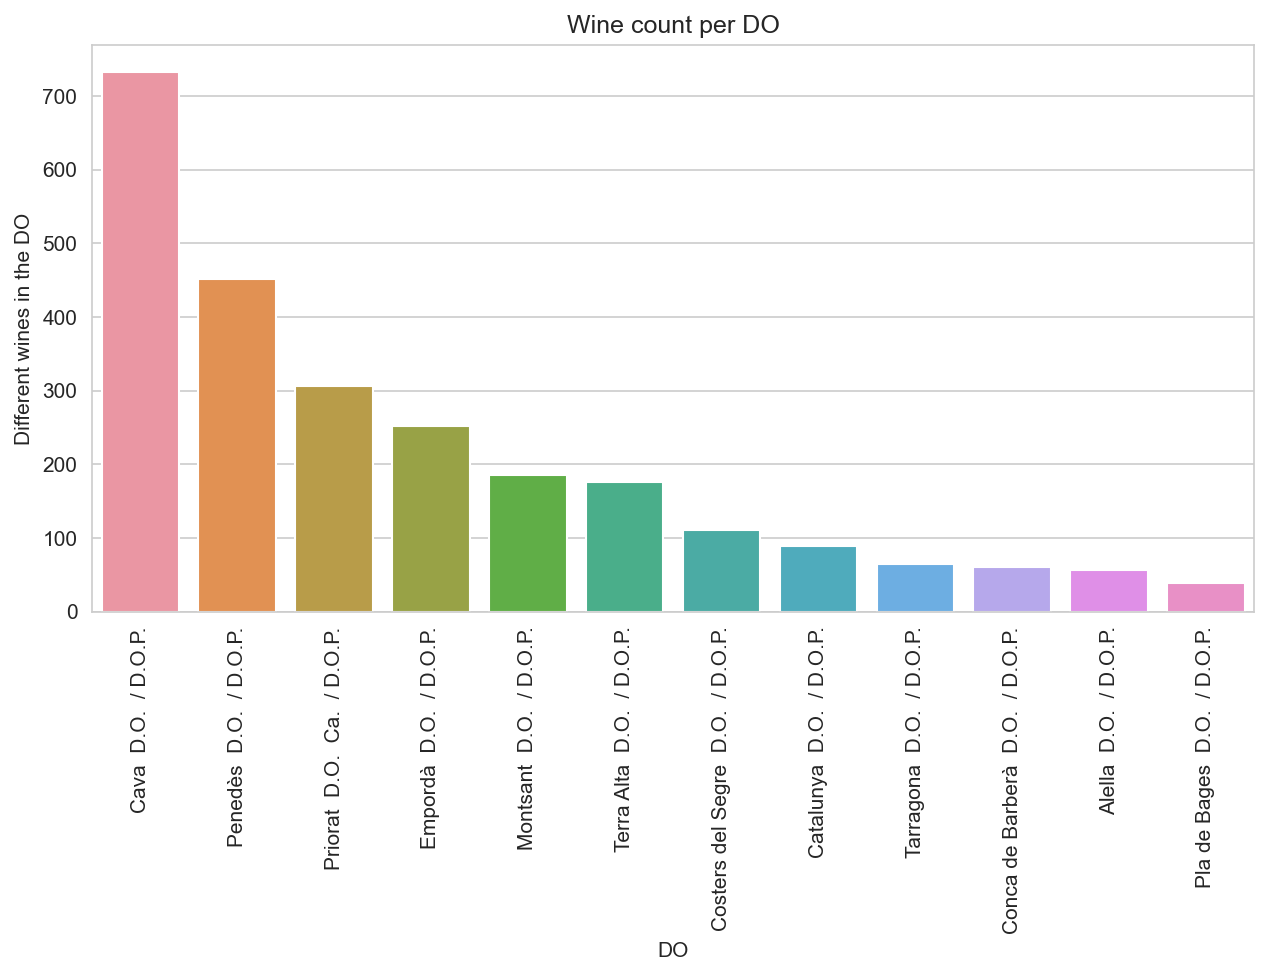

In [40]:
plt.figure(figsize=(10,5),dpi=150)
y_count = pd.melt(y,var_name='DO', value_name='WineInDO')
y_count = y_count[y_count.WineInDO==1]
y_count = y_count.groupby(["DO"])["WineInDO"].sum().reset_index()
sns.barplot(x="DO",y="WineInDO",data=y_count.sort_values(by="WineInDO",ascending=False));
plt.ylabel("Different wines in the DO")
plt.xticks(rotation=90)
plt.title("Wine count per DO");


In order to take into account this biased dataset we need to ponderate the error. There are several methods for example:

- Balanced weight: Sklearn will apply: ```n_samples / (n_classes * np.bincount(y))```
- SQRT Balanced weight will apply: ```np.sqrt( n_samples / (n_classes * np.bincount(y)) )```

From now on **we will use the SQRT sample weight** in order to smooth the class weight peaks for the classes that have really few sample i,e Pla del Bages that only has 39 samples vs Priorat with nearly 307:

In [41]:
# reoder y_count
new_y_count=pd.DataFrame(columns=["DO", "WineInDO"])
for train_do in y_train.columns:
    

    entry = pd.DataFrame.from_dict({"DO": [train_do],"WineInDO": [y_count[y_count.DO==train_do].WineInDO.values[0]]})
    new_y_count = pd.concat([new_y_count, entry], ignore_index=True)
y_count = new_y_count.copy()
y_count

DO WineInDO
0                Cava  D.O.  / D.O.P.      732
1          Terra Alta  D.O.  / D.O.P.      176
2   Costers del Segre  D.O.  / D.O.P.      111
3    Conca de Barberà  D.O.  / D.O.P.       61
4        Priorat  D.O.  Ca.  / D.O.P.      307
5           Tarragona  D.O.  / D.O.P.       65
6             Penedès  D.O.  / D.O.P.      451
7             Empordà  D.O.  / D.O.P.      252
8           Catalunya  D.O.  / D.O.P.       89
9              Alella  D.O.  / D.O.P.       57
10           Montsant  D.O.  / D.O.P.      186
11       Pla de Bages  D.O.  / D.O.P.       39

In [42]:
y_count["balanced_weight"] = y_count.WineInDO.max() / y_count.WineInDO
y_count["SQRTbalanced_weight"] = y_count.balanced_weight**.5
y_count

DO WineInDO balanced_weight  \
0                Cava  D.O.  / D.O.P.      732             1.0   
1          Terra Alta  D.O.  / D.O.P.      176        4.159091   
2   Costers del Segre  D.O.  / D.O.P.      111        6.594595   
3    Conca de Barberà  D.O.  / D.O.P.       61            12.0   
4        Priorat  D.O.  Ca.  / D.O.P.      307        2.384365   
5           Tarragona  D.O.  / D.O.P.       65       11.261538   
6             Penedès  D.O.  / D.O.P.      451         1.62306   
7             Empordà  D.O.  / D.O.P.      252        2.904762   
8           Catalunya  D.O.  / D.O.P.       89        8.224719   
9              Alella  D.O.  / D.O.P.       57       12.842105   
10           Montsant  D.O.  / D.O.P.      186        3.935484   
11       Pla de Bages  D.O.  / D.O.P.       39       18.769231   

   SQRTbalanced_weight  
0                  1.0  
1             2.039385  
2             2.567994  
3             3.464102  
4             1.544139  
5             3.355822  
6             1.273994  
7             1.704336  
8             2.867877  
9             3.583588  
10            1.983805  
11            4.332347

In [43]:
# Calculate the weight ponderation based on SQRT
sqrt_mapping_values = y_count.set_index("DO")["SQRTbalanced_weight"].to_dict()

y_train_sqrt = y_train.idxmax(axis=1).map(sqrt_mapping_values)
y_test_sqrt = y_test.idxmax(axis=1).map(sqrt_mapping_values)

We can see now that with the new SQRT score weights the accuracy is much lower:

In [44]:
clf.score(X_test,y_test.idxmax(axis=1),y_test_sqrt)

0.3454806954004449

RandomForestClassifier allows to weight each class:

In [45]:
clf_balanced = RandomForestClassifier(class_weight=sqrt_mapping_values)
clf_balanced.fit(X_train, y_train.idxmax(axis=1))
clf_balanced.score(X_test,y_test.idxmax(axis=1),y_test_sqrt)

0.34218491457031064

Not much an improvement...

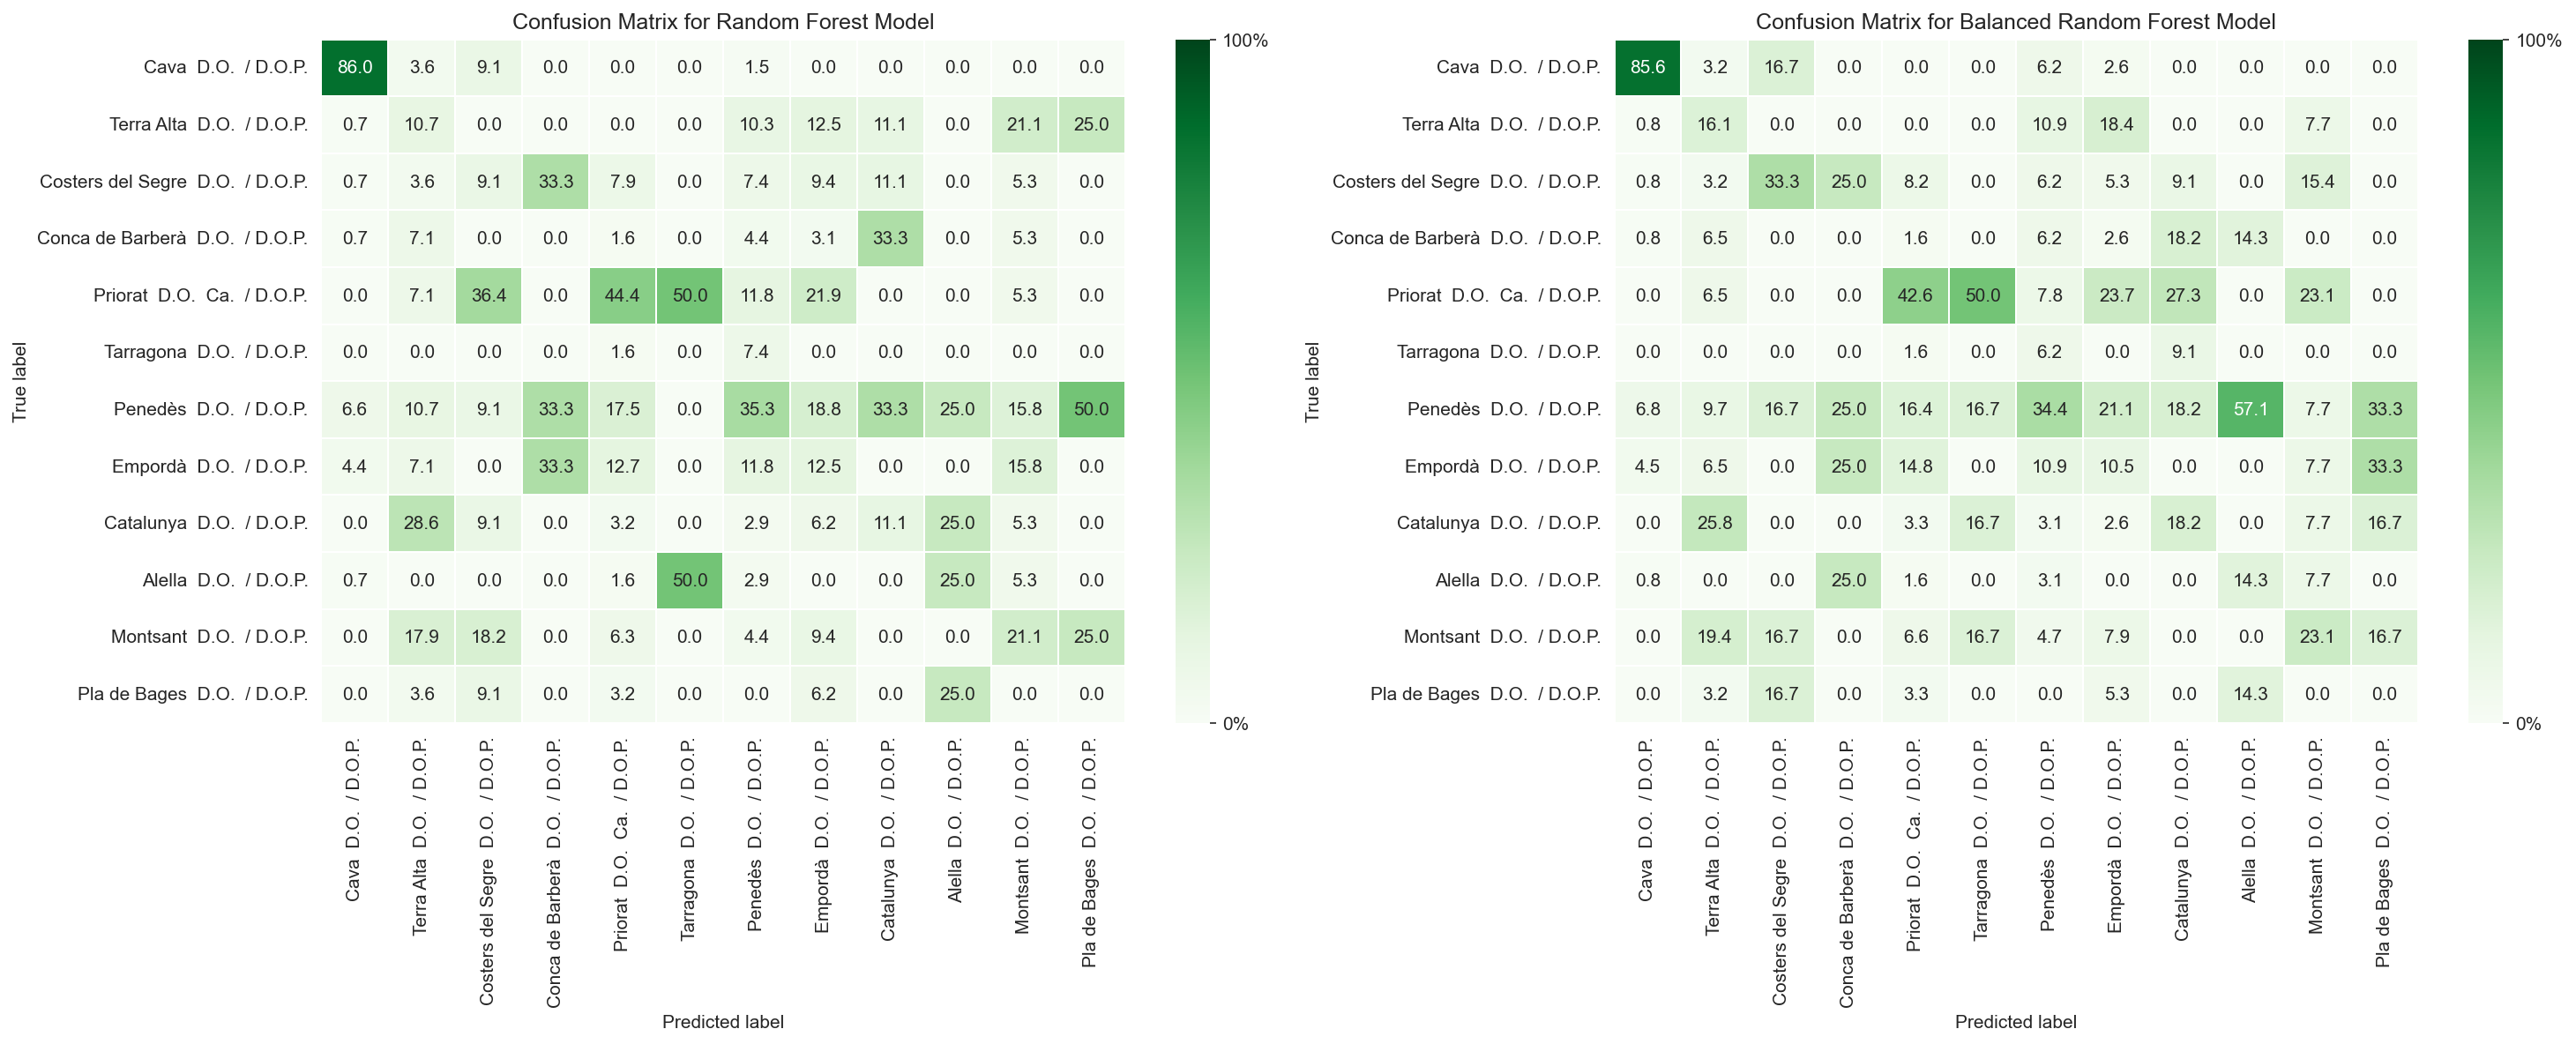

In [46]:
plt.figure(figsize=(20,8),dpi=150)

for i,predictor,title in [[1,clf,"Confusion Matrix for Random Forest Model"],[2,clf_balanced,"Confusion Matrix for Balanced Random Forest Model"]]:

    plt.subplot(1, 2, i)
    create_confusion_matrix(predictor,X_test,y_test,title=title)

plt.tight_layout()

We are improving a little bit with the RF balanced mode but still our predictor is really *biased* against *Cava DO*

### Random Hyperparameter Grid with CrossValidation

To try to imporve the accuracy of the randomforest we can finetune its hyperparameters

In [47]:
    from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 1000, stop = 2100, num = 25)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 50, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4,6]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [1000, 1045, 1091, 1137, 1183, 1229, 1275, 1320, 1366, 1412, 1458, 1504, 1550, 1595, 1641, 1687, 1733, 1779, 1825, 1870, 1916, 1962, 2008, 2054, 2100], 'max_features': ['auto', 'sqrt'], 'max_depth': [2, 6, 11, 16, 21, 26, 30, 35, 40, 45, 50, None], 'min_samples_split': [2, 5], 'min_samples_leaf': [2, 4, 6], 'bootstrap': [True, False]}


In [48]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
clf_grid = RandomForestClassifier(class_weight=sqrt_mapping_values)

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = clf_grid, param_distributions = random_grid, n_iter = 200, cv = 5, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train.idxmax(axis=1))

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight={'Alella  D.O.  / D.O.P.': 3.583588322220885,
                                                                  'Catalunya  D.O.  / D.O.P.': 2.8678771070468825,
                                                                  'Cava  D.O.  / D.O.P.': 1.0,
                                                                  'Conca de Barberà  D.O.  / D.O.P.': 3.4641016151377544,
                                                                  'Costers del Segre  D.O.  / D.O.P.': 2.567994274642098,
                                                                  'Empordà  D.O.  / D.O.P.': 1.7043362064926932,
                                                                  'Montsant  D.O.  / D.O.P.': 1.9838054014866837,
                                                                  'P...
                   n_iter=200, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
 

In [49]:
rf_random.best_params_

{'n_estimators': 1366,
 'min_samples_split': 5,
 'min_samples_leaf': 6,
 'max_features': 'auto',
 'max_depth': 16,
 'bootstrap': True}

In [50]:
best_grid = rf_random.best_estimator_
best_grid.score(X_test,y_test.idxmax(axis=1),y_test_sqrt)

0.3711812462028979

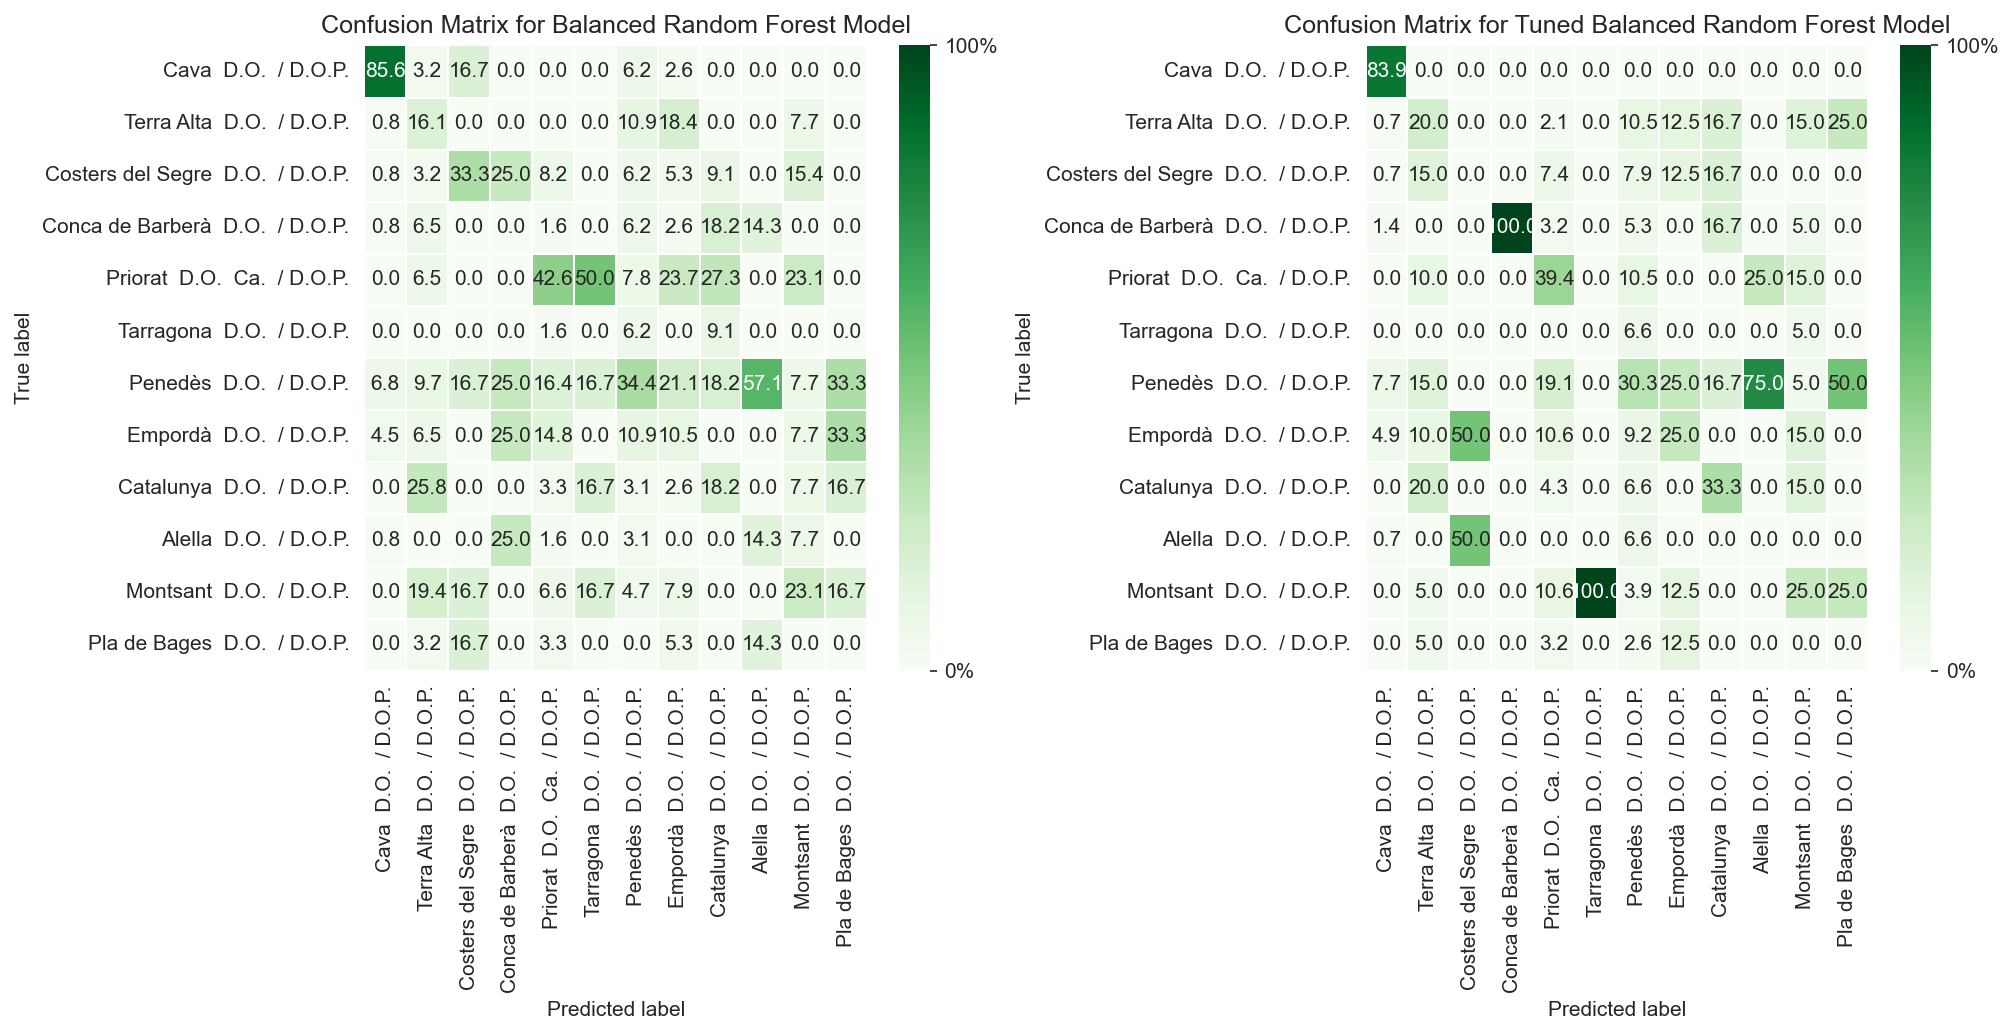

In [51]:
plt.figure(figsize=(13.5,7),dpi=150)

for i,predictor,title in [[1,clf_balanced,"Confusion Matrix for Balanced Random Forest Model"],[2,best_grid,"Confusion Matrix for Tuned Balanced Random Forest Model"]]:

    plt.subplot(1, 2, i)
    create_confusion_matrix(predictor,X_test,y_test,title=title)

plt.tight_layout()


As it can be seen by finetuning a balanced Random Forest we are not gaining that much, thus, **we need to explore other models**

## CatBoost model

### Default implementation

https://towardsdatascience.com/5-cute-features-of-catboost-61532c260f69#:~:text=CatBoost%20has%20built%2Din%20parameters%20to%20reduce%20overfitting&text=The%20default%20value%20is%20False,process%20early%20to%20reduce%20overfitting.

In [71]:
X_train_cat, X_val, y_train_cat, y_val = train_test_split(X_train, y_train, train_size=0.85, random_state=1)
print(y_val.shape)

(323, 12)


In [72]:
y_train_cat_org = y_train_cat.idxmax(axis=1)
y_train_org = y_train.idxmax(axis=1)
y_val_org = y_val.idxmax(axis=1)
y_test_org = y_test.idxmax(axis=1)

In [73]:
cat_clf_sqrtbalanced = CatBoostClassifier(loss_function='MultiClass',eval_metric="Accuracy",auto_class_weights="SqrtBalanced",task_type="GPU",devices='0')

cat_clf_sqrtbalanced.fit(X_train_cat, y_train_cat_org,
        eval_set=(X_val,y_val_org),early_stopping_rounds=100)

Learning rate set to 0.111736
0:	learn: 0.3294525	test: 0.3278962	best: 0.3278962 (0)	total: 106ms	remaining: 1m 46s
1:	learn: 0.3518840	test: 0.3362757	best: 0.3362757 (1)	total: 121ms	remaining: 1m
2:	learn: 0.3463151	test: 0.3278892	best: 0.3362757 (1)	total: 264ms	remaining: 1m 27s
3:	learn: 0.3537325	test: 0.3329192	best: 0.3362757 (1)	total: 327ms	remaining: 1m 21s
4:	learn: 0.3576664	test: 0.3338749	best: 0.3362757 (1)	total: 341ms	remaining: 1m 7s
5:	learn: 0.3533315	test: 0.3393601	best: 0.3393601 (5)	total: 390ms	remaining: 1m 4s
6:	learn: 0.3663883	test: 0.3328770	best: 0.3393601 (5)	total: 472ms	remaining: 1m 7s
7:	learn: 0.3678798	test: 0.3380300	best: 0.3393601 (5)	total: 561ms	remaining: 1m 9s
8:	learn: 0.3694391	test: 0.3422364	best: 0.3422364 (8)	total: 693ms	remaining: 1m 16s
9:	learn: 0.3723759	test: 0.3444136	best: 0.3444136 (9)	total: 712ms	remaining: 1m 10s
10:	learn: 0.3746312	test: 0.3434533	best: 0.3444136 (9)	total: 738ms	remaining: 1m 6s
11:	learn: 0.3832708	

### Confusion Matrix

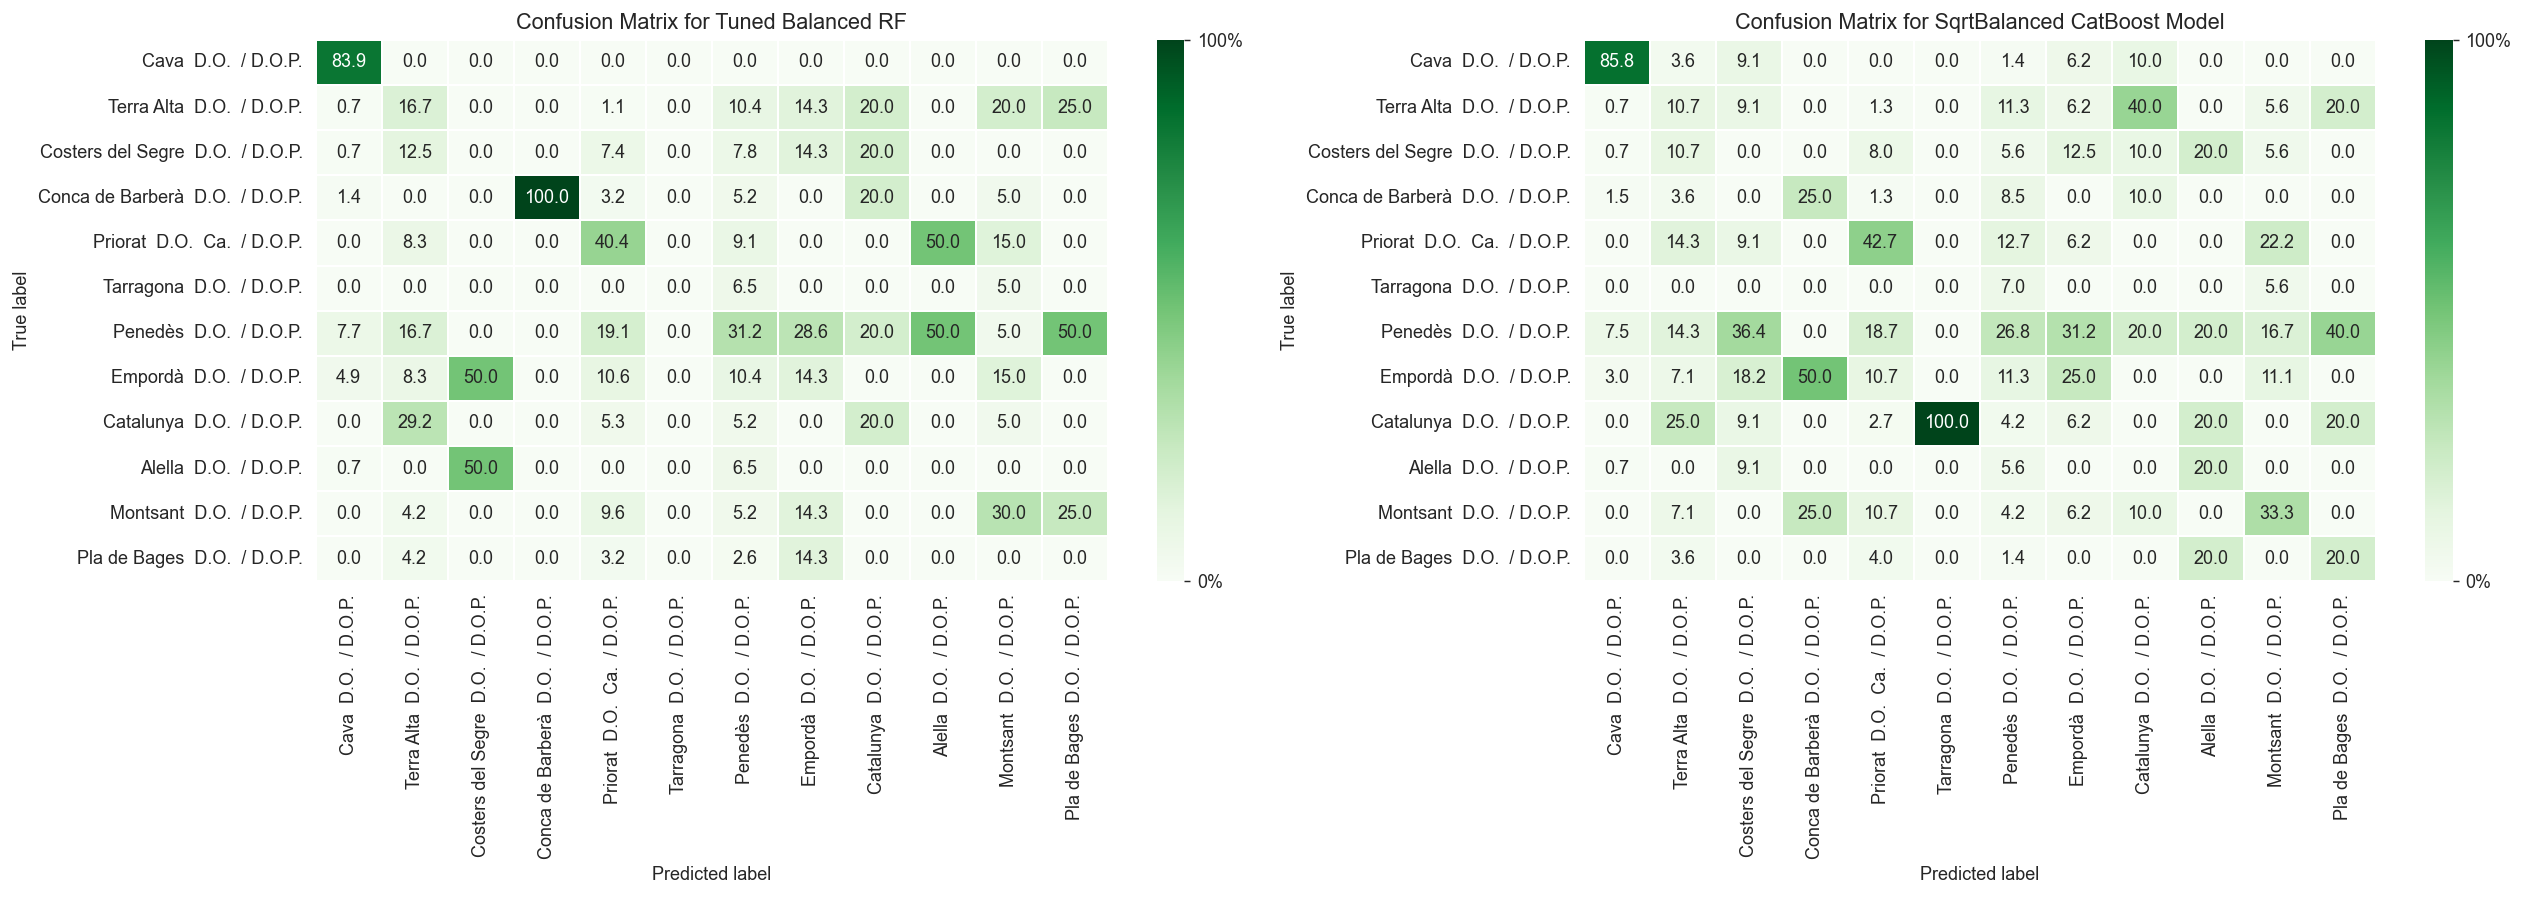

In [74]:
plt.figure(figsize=(20,7),dpi=130)

for i,predictor,title in [[1,best_grid,"Confusion Matrix for Tuned Balanced RF"],[2,cat_clf_sqrtbalanced,"Confusion Matrix for SqrtBalanced CatBoost Model"]]:

    plt.subplot(1, 2, i)
    create_confusion_matrix(predictor,X_test,y_test,title=title)

plt.tight_layout()

It does look like that we are having a more diagonal confusion matrix when using the Balanced option in the CatBoost Option:

In [75]:
# reoder and create a dictionary that will SQRT weight the samples
sqrt_weight={}
plan_weight={}
i=0
for do in y_train.columns:
    sqrt_weight[i] =y_count[y_count.DO==do].SQRTbalanced_weight.values[0]
    plan_weight[i] = 1
    i+=1

In [76]:
from sklearn.metrics import accuracy_score


def get_sqrt_score(y_true,predictor,X_train,weights_dict=sqrt_weight):
    y_pred_val = predictor.predict(X_train)
    return accuracy_score(y_true.idxmax(axis=1),y_pred_val,sample_weight=np.vectorize(weights_dict.get)((y_true.values.argmax(axis=1))))


In [84]:
get_sqrt_score(y_true=y_train,predictor=cat_clf_sqrtbalanced,X_train=X_train,weights_dict=sqrt_weight)

0.5241602274161459

In [77]:
get_sqrt_score(y_true=y_test,predictor=cat_clf_sqrtbalanced,X_train=X_test,weights_dict=sqrt_weight)

0.3519531584322614

### Hyperparameter tunning

In [112]:
cat_clf_balanced_tuned = CatBoostClassifier(loss_function='MultiClass',eval_metric="Accuracy",auto_class_weights="SqrtBalanced",task_type="GPU",devices='0')

In [113]:
grid = {'learning_rate': [0.02, 0.03,0.04,0.1,0.15],
        'depth': [2,3,4,5, 6,7,8, 10,],
        'l2_leaf_reg': [1, 3, 5, 6,10],
        'early_stopping_rounds':[10,50,100,110,150,200]}

In [114]:
# This method uses cross-validation, therfore we can join the training and the validation dataset
randomized_search_result = cat_clf_balanced_tuned.randomized_search(grid,X_train, y_train_org,cv=5,n_iter=200)

0:	learn: 0.2756391	test: 0.2779809	best: 0.2779809 (0)	total: 7.04ms	remaining: 7.04s
1:	learn: 0.2975564	test: 0.2955263	best: 0.2955263 (1)	total: 14.6ms	remaining: 7.27s
2:	learn: 0.2975564	test: 0.2955263	best: 0.2955263 (1)	total: 20.6ms	remaining: 6.86s
3:	learn: 0.2975564	test: 0.2955263	best: 0.2955263 (1)	total: 27ms	remaining: 6.72s
4:	learn: 0.2975564	test: 0.2955263	best: 0.2955263 (1)	total: 32.6ms	remaining: 6.49s
5:	learn: 0.3254203	test: 0.3387467	best: 0.3387467 (5)	total: 38.3ms	remaining: 6.34s
6:	learn: 0.3255203	test: 0.3387467	best: 0.3387467 (5)	total: 45.5ms	remaining: 6.45s
7:	learn: 0.3254203	test: 0.3387467	best: 0.3387467 (5)	total: 51.2ms	remaining: 6.34s
8:	learn: 0.3254203	test: 0.3387467	best: 0.3387467 (5)	total: 56.8ms	remaining: 6.25s
9:	learn: 0.3142145	test: 0.3322429	best: 0.3387467 (5)	total: 63.7ms	remaining: 6.31s
10:	learn: 0.3254203	test: 0.3387467	best: 0.3387467 (5)	total: 69.4ms	remaining: 6.24s
11:	learn: 0.3249488	test: 0.3387467	best: 0

In [115]:
randomized_search_result["params"]

{'depth': 5, 'od_wait': 110, 'l2_leaf_reg': 3, 'learning_rate': 0.1}

In [116]:
get_sqrt_score(y_true=y_train,predictor=cat_clf_balanced_tuned,X_train=X_train,weights_dict=sqrt_weight)

0.7859560117110057

In [117]:
get_sqrt_score(y_true=y_test,predictor=cat_clf_balanced_tuned,X_train=X_test,weights_dict=sqrt_weight)

0.3555296552249434

### Selecting the best way to recommend a DO

In the wine world everything is not always black and white. Most of the times we have a grey zone, for example it's really plausible that a person that likes Priorat wines (strong flavoured, slate floor, tanic...) could be also be interested in Emporda or Montsant. The objetive of this part is to recommend to check if we can recommend the minimum number of DO to get the target one.

First let's check how our best algorithm so far **cat_clf_balanced_tuned model**  predicts:

In [69]:
predictions = cat_clf_balanced_tuned.predict_proba(X_test)
max_predictions = predictions.max(axis=1)

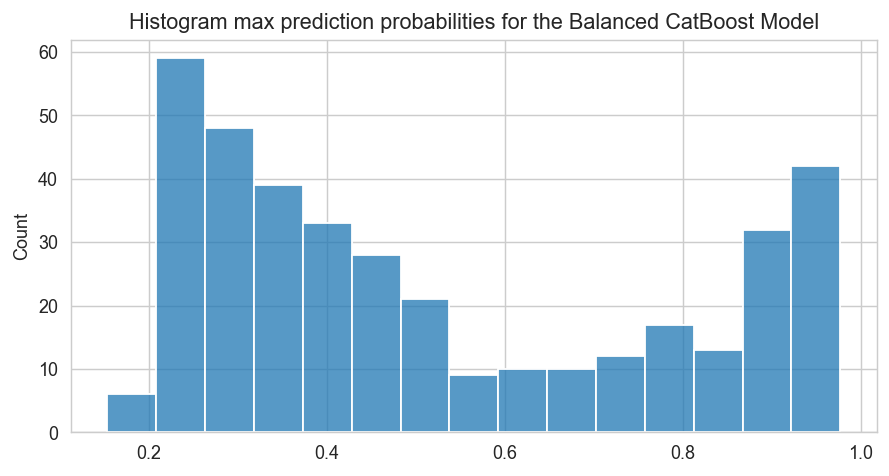

In [70]:
plt.figure(figsize=(8,4),dpi=130)
sns.histplot(max_predictions,bins=15)
plt.title("Histogram max prediction probabilities for the Balanced CatBoost Model");

We observe a binomial distribution when the algorithm is really sure and others that doubts (low max prediction probability). Let's imagine that we could offer X different DO, what will be the sqrt ponderated accuracy?

Let's find out:

In [37]:
# create a dictionary that will get the order of the caterogical variables in the Catboost and convert to the order of the first DataFrame saved in y_cols

i = 0
cat2y_cols = {}
y_cols = y_test.columns

for do in cat_clf_balanced_tuned.classes_:

    j=0
    for do_y in y_cols:
        if do == do_y:
            cat2y_cols[i] = j
        j += 1
    i+= 1

cat2y_cols


{0: 9, 1: 8, 2: 0, 3: 3, 4: 2, 5: 7, 6: 10, 7: 6, 8: 11, 9: 4, 10: 5, 11: 1}

In [38]:
def predict_classes(proba,max_len_recomendation=2):

    lst = pd.Series(proba)
    last_max = lst.nlargest(max_len_recomendation).values[-1]
    bin_prova = proba >= last_max
    return  bin_prova * 1

In [39]:
def overall_acuracy(clf,X,y,max_len_recomendation,ycols_dict= cat2y_cols,weights_dict=sqrt_weight):

    y_final = []

    for i in range(len(X)):
        predictions = predict_classes(clf.predict_proba(X)[i],max_len_recomendation)
        predictions = np.where(predictions==1)[0].tolist()

        #Translate
        predictions = [ycols_dict[x] for x in predictions]

        label = y.iloc[i].values.argmax()

        if label in predictions:
            y_final.append(label)
        else:
             y_final.append(0)

    y_final = np.asarray(y_final)
    return accuracy_score(y.values.argmax(axis=1),y_final,sample_weight=np.vectorize(weights_dict.get)((y.values.argmax(axis=1))))




In [102]:
overall_acuracy(cat_clf_balanced_tuned,X_test,y_test,max_len_recomendation=3)

0.5744457860676501

In [41]:
overall_acuracy(cat_clf_balanced_tuned,X_test,y_test,max_len_recomendation=3,weights_dict=plan_weight)

0.6912928759894459

### Modify CatBoostClassifier

In [42]:
from predictDO import multiple_CatBoostClassifier
%load_ext autoreload
%autoreload 2

In [43]:
y_train_org = y_train.idxmax(axis=1)
y_val_org = y_val.idxmax(axis=1)
y_test_org = y_test.idxmax(axis=1)
final_clf_catboost = multiple_CatBoostClassifier(loss_function='MultiClass',eval_metric="Accuracy",auto_class_weights="SqrtBalanced",task_type="GPU",devices='0')
randomized_search_result = final_clf_catboost.randomized_search(grid,pd.concat((X_train,X_val)), pd.concat((y_train_org,y_val_org)))

0:	learn: 0.3237840	test: 0.3087309	best: 0.3087309 (0)	total: 10.9ms	remaining: 10.9s
1:	learn: 0.3373136	test: 0.3330491	best: 0.3330491 (1)	total: 21.2ms	remaining: 10.6s
2:	learn: 0.3307195	test: 0.3013056	best: 0.3330491 (1)	total: 34.5ms	remaining: 11.5s
3:	learn: 0.3350725	test: 0.3353354	best: 0.3353354 (3)	total: 44.9ms	remaining: 11.2s
4:	learn: 0.3429382	test: 0.3356422	best: 0.3356422 (4)	total: 57.7ms	remaining: 11.5s
5:	learn: 0.3499380	test: 0.3342581	best: 0.3356422 (4)	total: 67.8ms	remaining: 11.2s
6:	learn: 0.3544890	test: 0.3287702	best: 0.3356422 (4)	total: 77.9ms	remaining: 11.1s
7:	learn: 0.3602691	test: 0.3371026	best: 0.3371026 (7)	total: 90.6ms	remaining: 11.2s
8:	learn: 0.3578938	test: 0.3346557	best: 0.3371026 (7)	total: 101ms	remaining: 11.1s
9:	learn: 0.3615999	test: 0.3322469	best: 0.3371026 (7)	total: 114ms	remaining: 11.3s
10:	learn: 0.3645044	test: 0.3349766	best: 0.3371026 (7)	total: 124ms	remaining: 11.1s
11:	learn: 0.3659081	test: 0.3355516	best: 0.

In [44]:
final_clf_catboost.predict(X_val.iloc[11])

array(['Cava  D.O.  / D.O.P.'], dtype=object)

In [45]:
final_clf_catboost.predict_do(['tinto', 'maduro','persistente','con personalidad'])

OrderedDict([('Montsant  D.O.  / D.O.P.', 0.32658225347196546),
             ('Priorat  D.O.  Ca.  / D.O.P.', 0.2526361087113917),
             ('Penedès  D.O.  / D.O.P.', 0.1856706463670829),
             ('Catalunya  D.O.  / D.O.P.', 0.14633336043016362),
             ('Empordà  D.O.  / D.O.P.', 0.06877386929590242),
             ('Costers del Segre  D.O.  / D.O.P.', 0.00678509437620132),
             ('Terra Alta  D.O.  / D.O.P.', 0.00391068230966078),
             ('Conca de Barberà  D.O.  / D.O.P.', 0.0026099250744342248),
             ('Pla de Bages  D.O.  / D.O.P.', 0.0023860109806803985),
             ('Cava  D.O.  / D.O.P.', 0.0022790658628454876),
             ('Alella  D.O.  / D.O.P.', 0.0017605294045459174),
             ('Tarragona  D.O.  / D.O.P.', 0.0002724537151257889)])

In [46]:
final_clf_catboost.predict_do(['blanco',"herbal"])

OrderedDict([('Penedès  D.O.  / D.O.P.', 0.5281687940359332),
             ('Catalunya  D.O.  / D.O.P.', 0.24782820270275954),
             ('Empordà  D.O.  / D.O.P.', 0.11401017289334563),
             ('Terra Alta  D.O.  / D.O.P.', 0.05641176122567601),
             ('Alella  D.O.  / D.O.P.', 0.03127518415257563),
             ('Montsant  D.O.  / D.O.P.', 0.013531177221960634),
             ('Pla de Bages  D.O.  / D.O.P.', 0.0025263915786146204),
             ('Costers del Segre  D.O.  / D.O.P.', 0.0020660753592654326),
             ('Tarragona  D.O.  / D.O.P.', 0.0020389964494446373),
             ('Cava  D.O.  / D.O.P.', 0.0008270503591757725),
             ('Priorat  D.O.  Ca.  / D.O.P.', 0.0007506161420925512),
             ('Conca de Barberà  D.O.  / D.O.P.', 0.0005655778791563237)])

In [47]:
final_clf_catboost.predict_do(['tinto','mineral'])

OrderedDict([('Empordà  D.O.  / D.O.P.', 0.49573422300858827),
             ('Priorat  D.O.  Ca.  / D.O.P.', 0.22161106687571278),
             ('Penedès  D.O.  / D.O.P.', 0.1374302225588778),
             ('Catalunya  D.O.  / D.O.P.', 0.10660433257924673),
             ('Montsant  D.O.  / D.O.P.', 0.01218259033920051),
             ('Alella  D.O.  / D.O.P.', 0.01160574781798392),
             ('Costers del Segre  D.O.  / D.O.P.', 0.010122025721976525),
             ('Conca de Barberà  D.O.  / D.O.P.', 0.0023422127384837405),
             ('Pla de Bages  D.O.  / D.O.P.', 0.0008536130579306091),
             ('Terra Alta  D.O.  / D.O.P.', 0.0006943253843829583),
             ('Tarragona  D.O.  / D.O.P.', 0.00044252231999674697),
             ('Cava  D.O.  / D.O.P.', 0.0003771175976192837)])

Save it into a pickle file>

In [48]:
file_to_store = open("predictDO.pickle", "wb")
pickle.dump(final_clf_catboost, file_to_store)

file_to_store.close()

## Autogluon

In [21]:
train_set = X_train.copy()
test_set  = X_test.copy()


train_set["label"] = y_train.idxmax(axis=1)
test_set["label"] = y_test.idxmax(axis=1)

train_set["sqrt_weight"] = train_set.label.map(sqrt_mapping_values)
test_set["sqrt_weight"]  = test_set.label.map(sqrt_mapping_values)


In [22]:
train_data = TabularDataset(train_set)
test_data = TabularDataset(test_set)
train_data.head()

blanco  tinto  espumoso  rosado  corpulento  sabroso  frutal  \
1631       0      1         0       0           1        0       0   
619        0      0         1       0           0        0       1   
1853       0      0         1       0           1        1       0   
1852       1      0         0       0           1        0       0   
1376       0      0         1       0           0        1       0   

      equilibrado  cítrico  especiado  ...  cálido  mineral  tropical  \
1631            0        0          1  ...       0        0         0   
619             0        1          0  ...       0        0         0   
1853            1        0          0  ...       0        0         0   
1852            0        0          1  ...       0        1         0   
1376            0        1          1  ...       0        0         0   

      varietal  clásico  carnoso  cremoso  rústico  \
1631         0        0        0        0        0   
619          0        0        0        0        0   
1853         0        0        0        0        0   
1852         0        0        0        0        0   
1376         0        0        0        0        0   

                                  label  sqrt_weight  
1631  Costers del Segre  D.O.  / D.O.P.     2.567994  
619                Cava  D.O.  / D.O.P.     1.000000  
1853               Cava  D.O.  / D.O.P.     1.000000  
1852             Alella  D.O.  / D.O.P.     3.583588  
1376               Cava  D.O.  / D.O.P.     1.000000  

[5 rows x 38 columns]

### Training

In [18]:
auto_predictor = TabularPredictor(label="label",
eval_metric="accuracy",sample_weight="sqrt_weight",weight_evaluation=True
).fit(train_data,presets='high_quality',ag_args_ensemble={"fold_fitting_strategy":"sequential_local"})

No path specified. Models will be saved in: "AutogluonModels/ag-20220820_164753\"
Presets specified: ['high_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Values in column 'sqrt_weight' used as sample weights instead of predictive features. Evaluation will report weighted metrics, so ensure same column exists in test data.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20220820_164753\"
AutoGluon Version:  0.5.2
Python Version:     3.9.12
Operating System:   Windows
Train Data Rows:    2147
Train Data Columns: 37
Label Column: label
Preprocessing data ...
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == object).
	First 10 (of 12) unique label values:  ['Costers del Segre  D.O.  / D.O.P.', 'Cava  D.O.  / D.O.P.', 'Alella  D.O.  / D.O.P.', 'Empordà  D.O.  / D.O.P.', 'Priorat  D.O.  Ca.  / D.O.P.', 'Catalunya  D.O.  / D.O.P.', 'Penedès  D.O.  / D.O.P.', 'Mon

[1000]	valid_set's multi_error: 0.600497


	0.4019	 = Validation score   (accuracy)
	79.68s	 = Training   runtime
	0.16s	 = Validation runtime
Fitting model: LightGBM_BAG_L2 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	0.3776	 = Validation score   (accuracy)
	89.25s	 = Training   runtime
	0.13s	 = Validation runtime
Fitting model: RandomForestGini_BAG_L2 ...
	0.3531	 = Validation score   (accuracy)
	0.82s	 = Training   runtime
	0.19s	 = Validation runtime
Fitting model: RandomForestEntr_BAG_L2 ...
	0.3432	 = Validation score   (accuracy)
	1.56s	 = Training   runtime
	0.23s	 = Validation runtime
Fitting model: CatBoost_BAG_L2 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	0.3638	 = Validation score   (accuracy)
	568.58s	 = Training   runtime
	0.08s	 = Validation runtime
Fitting model: ExtraTreesGini_BAG_L2 ...
	0.3503	 = Validation score   (accuracy)
	0.65s	 = Training   runtime
	0.18s	 = Validation runtime
Fitting model: ExtraTreesEntr

### Testing

In [143]:
auto_predictor = TabularPredictor.load(r"AutogluonModels/ag-20220820_164753/")

In [144]:
auto_predictor.leaderboard(test_data, silent=True)

model  score_test  score_val  pred_time_test  \
0         LightGBMXT_BAG_L2_FULL    0.390741        NaN        0.968454   
1       WeightedEnsemble_L3_FULL    0.390741        NaN        1.066454   
2           CatBoost_BAG_L1_FULL    0.386787        NaN        0.005002   
3       WeightedEnsemble_L2_FULL    0.386787        NaN        0.010647   
4     ExtraTreesGini_BAG_L2_FULL    0.372696        NaN        0.964755   
5         LightGBMXT_BAG_L1_FULL    0.370042        NaN        0.024998   
6           LightGBM_BAG_L1_FULL    0.370042        NaN        0.026001   
7            XGBoost_BAG_L1_FULL    0.368087        NaN        0.008043   
8   RandomForestEntr_BAG_L2_FULL    0.363983        NaN        0.974442   
9   RandomForestGini_BAG_L2_FULL    0.359153        NaN        0.970702   
10          LightGBM_BAG_L2_FULL    0.359034        NaN        0.890457   
11    ExtraTreesEntr_BAG_L2_FULL    0.358364        NaN        0.979842   
12           XGBoost_BAG_L2_FULL    0.356382        NaN        0.810697   
13          CatBoost_BAG_L2_FULL    0.355944        NaN        0.809451   
14     LightGBMLarge_BAG_L1_FULL    0.347909        NaN        0.065002   
15    NeuralNetTorch_BAG_L1_FULL    0.343784        NaN        0.013998   
16    NeuralNetTorch_BAG_L2_FULL    0.342121        NaN        0.855467   
17   NeuralNetFastAI_BAG_L2_FULL    0.339647        NaN        0.883454   
18     LightGBMLarge_BAG_L2_FULL    0.337473        NaN        1.007492   
19    ExtraTreesGini_BAG_L1_FULL    0.335294        NaN        0.146001   
20         ExtraTreesGini_BAG_L1    0.335294   0.323708        0.170789   
21  RandomForestGini_BAG_L1_FULL    0.334075        NaN        0.156001   
22       RandomForestGini_BAG_L1    0.334075   0.317054        0.179938   
23    ExtraTreesEntr_BAG_L1_FULL    0.328051        NaN        0.147003   
24         ExtraTreesEntr_BAG_L1    0.328051   0.317230        0.171998   
25  RandomForestEntr_BAG_L1_FULL    0.325899        NaN        0.161403   
26       RandomForestEntr_BAG_L1    0.325899   0.319003        0.181001   
27   NeuralNetFastAI_BAG_L1_FULL    0.324408        NaN        0.034001   
28           WeightedEnsemble_L3         NaN   0.402151             NaN   
29             LightGBMXT_BAG_L2         NaN   0.401908             NaN   
30          LightGBMLarge_BAG_L2         NaN   0.377561             NaN   
31               LightGBM_BAG_L2         NaN   0.377559             NaN   
32                XGBoost_BAG_L2         NaN   0.375305             NaN   
33           WeightedEnsemble_L2         NaN   0.371656             NaN   
34               CatBoost_BAG_L1         NaN   0.371656             NaN   
35               CatBoost_BAG_L2         NaN   0.363750             NaN   
36        NeuralNetFastAI_BAG_L2         NaN   0.361023             NaN   
37             LightGBMXT_BAG_L1         NaN   0.357552             NaN   
38               LightGBM_BAG_L1         NaN   0.357552             NaN   
39                XGBoost_BAG_L1         NaN   0.354099             NaN   
40       RandomForestGini_BAG_L2         NaN   0.353061             NaN   
41        NeuralNetFastAI_BAG_L1         NaN   0.352401             NaN   
42         ExtraTreesGini_BAG_L2         NaN   0.350333             NaN   
43         ExtraTreesEntr_BAG_L2         NaN   0.346640             NaN   
44       RandomForestEntr_BAG_L2         NaN   0.343164             NaN   
45         NeuralNetTorch_BAG_L2         NaN   0.340024             NaN   
46         NeuralNetTorch_BAG_L1         NaN   0.339294             NaN   
47          LightGBMLarge_BAG_L1         NaN   0.325418             NaN   

    pred_time_val    fit_time  pred_time_test_marginal  \
0             NaN   18.547178                 0.181000   
1             NaN   20.440600                 0.002000   
2             NaN    1.651014                 0.005002   
3             NaN    2.294159                 0.005645   
4             NaN    9.766779                 0.177300   
5  

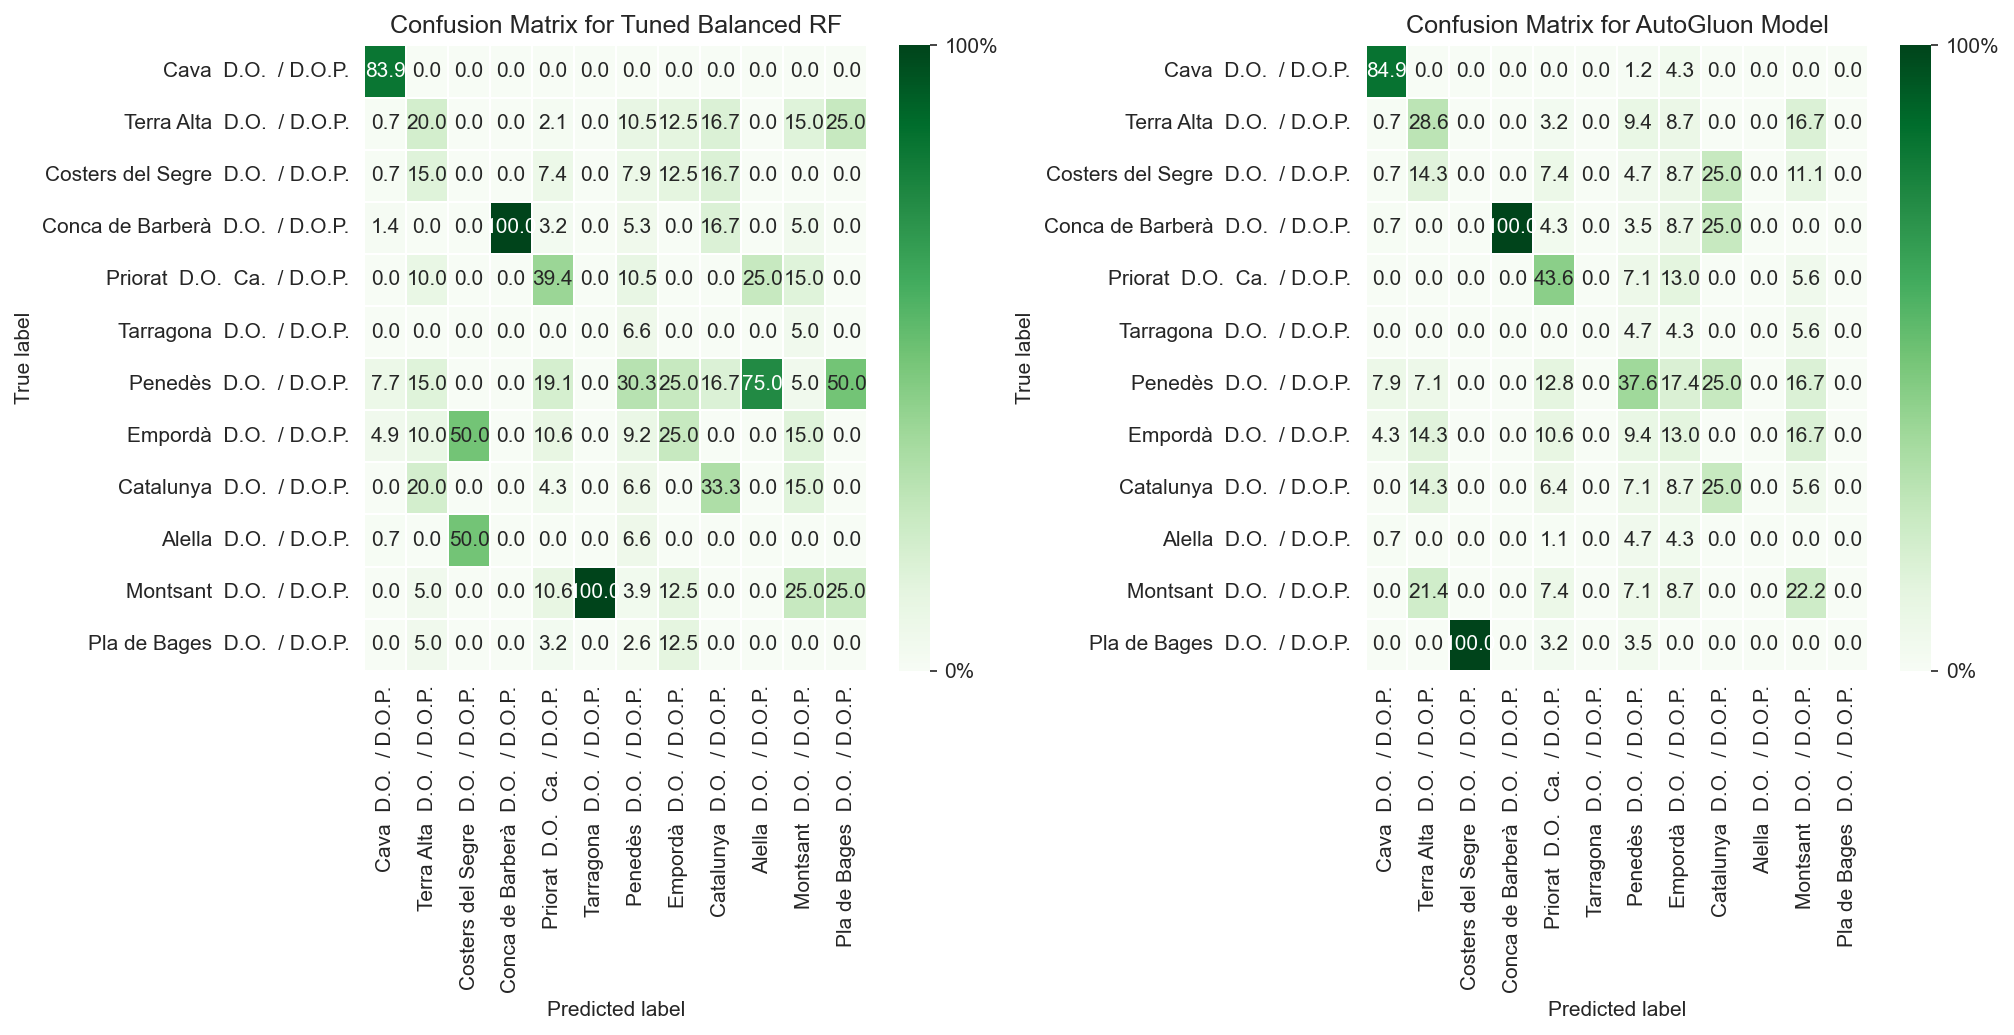

In [145]:
plt.figure(figsize=(13.5,7),dpi=150)

for i,predictor,title in [[1,best_grid,"Confusion Matrix for Tuned Balanced RF"],[2,auto_predictor,"Confusion Matrix for AutoGluon Model"]]:

    plt.subplot(1, 2, i)
    if i==2:
        create_confusion_matrix(predictor,X_test,y_test,title=title)
    else:
        create_confusion_matrix(predictor,X_test,y_test,title=title)

plt.tight_layout()

In [146]:
auto_predictor.feature_importance(test_data,model="CatBoost_BAG_L1_FULL")

These features in provided data are not utilized by the predictor and will be ignored: ['sqrt_weight']


importance    stddev   p_value  n  p99_high   p99_low
espumoso             0.223747  0.017442  0.000004  5  0.259660  0.187833
tinto                0.060686  0.004172  0.000003  5  0.069276  0.052096
rosado               0.024802  0.003540  0.000048  5  0.032091  0.017513
blanco               0.020053  0.009622  0.004795  5  0.039866  0.000240
frutal               0.020053  0.008046  0.002541  5  0.036620  0.003485
tostado              0.016887  0.004415  0.000513  5  0.025977  0.007796
suave                0.016887  0.004002  0.000352  5  0.025126  0.008647
herbal               0.015303  0.006017  0.002360  5  0.027692  0.002915
mineral              0.014776  0.001445  0.000011  5  0.017751  0.011800
persistente          0.012137  0.005471  0.003852  5  0.023403  0.000872
cítrico              0.007916  0.003232  0.002704  5  0.014569  0.001262
correcto             0.004749  0.007080  0.104000  5  0.019327 -0.009828
con defectos         0.003694  0.002360  0.012448  5  0.008553 -0.001165
silvestre            0.003694  0.004002  0.053969  5  0.011933 -0.004545
equilibrado          0.003166  0.006830  0.179228  5  0.017229 -0.010896
aromático            0.002111  0.002208  0.049650  5  0.006656 -0.002435
corpulento           0.002111  0.008003  0.293525  5  0.018589 -0.014368
floral               0.001583  0.004002  0.213159  5  0.009822 -0.006656
sabroso              0.001055  0.009254  0.405638  5  0.020109 -0.017998
oxidado              0.001055  0.003008  0.238310  5  0.007250 -0.005139
balsámico            0.001055  0.002360  0.186950  5  0.005915 -0.003804
clásico              0.000528  0.001180  0.186950  5  0.002957 -0.001902
elegante             0.000000  0.000000  0.500000  5  0.000000  0.000000
con vejez            0.000000  0.001866  0.500000  5  0.003842 -0.003842
cremoso              0.000000  0.000000  0.500000  5  0.000000  0.000000
carnoso              0.000000  0.000000  0.500000  5  0.000000  0.000000
cálido               0.000000  0.000000  0.500000  5  0.000000  0.000000
rústico              0.000000  0.000000  0.500000  5  0.000000  0.000000
notas de levadura    0.000000  0.000000  0.500000  5  0.000000  0.000000
tropical            -0.000528  0.001180  0.813050  5  0.001902 -0.002957
varietal            -0.000528  0.002208  0.689346  5  0.004018 -0.005073
fresco              -0.000528  0.002208  0.689346  5  0.004018 -0.005073
amargo              -0.001583  0.001445  0.964758  5  0.001393 -0.004559
taninos             -0.001583  0.001445  0.964758  5  0.001393 -0.004559
especiado           -0.002111  0.008003  0.706475  5  0.014368 -0.018589
dulce               -0.011082  0.002208  0.999821  5 -0.006536 -0.015627

In [26]:
predictions = auto_predictor.predict_proba(X_test)
max_predictions = predictions.max(axis=1)

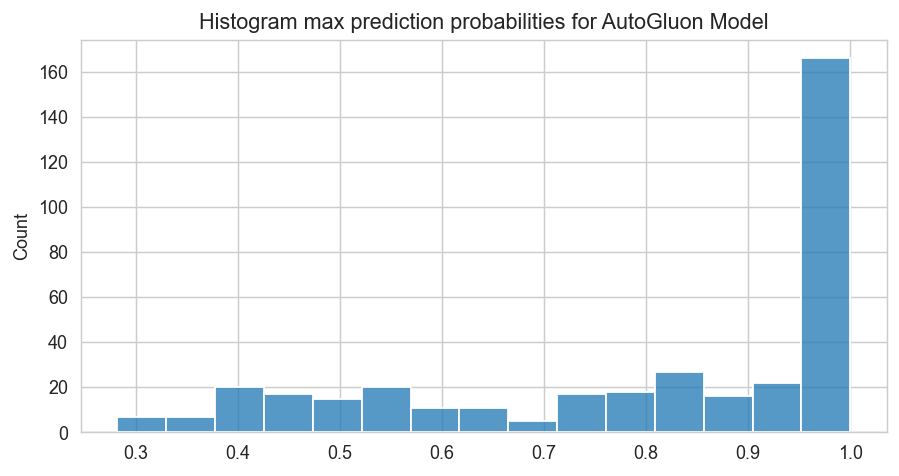

In [27]:
plt.figure(figsize=(8,4),dpi=130)
sns.histplot(max_predictions,bins=15)
plt.title("Histogram max prediction probabilities for AutoGluon Model");

In [137]:
predictions = auto_predictor.predict_proba(X_test).apply(lambda s, n: pd.Series(s.nlargest(n).index), axis=1, n=5)

predictions["label"] = y_test.idxmax(axis=1) 
predictions["sqrt_weight"] = predictions.label.map(sqrt_mapping_values)

predictions["correct"] = (predictions[0]==predictions["label"]) | (predictions[1]==predictions["label"]) | (predictions[2]==predictions["label"]) #| (predictions[3]==predictions["label"]) | (predictions[4]==predictions["label"]) 
predictions["correct_weight"] = (predictions.correct * predictions.sqrt_weight)

print(predictions.correct_weight.sum()/ predictions.sqrt_weight.sum())
print(predictions["correct"].mean())

0.6420309606931951
0.783641160949868


### Feature importance (Interpretability)

In [167]:
ft_importance = auto_predictor.feature_importance(pd.concat([train_data,test_data]))

These features in provided data are not utilized by the predictor and will be ignored: ['sqrt_weight']


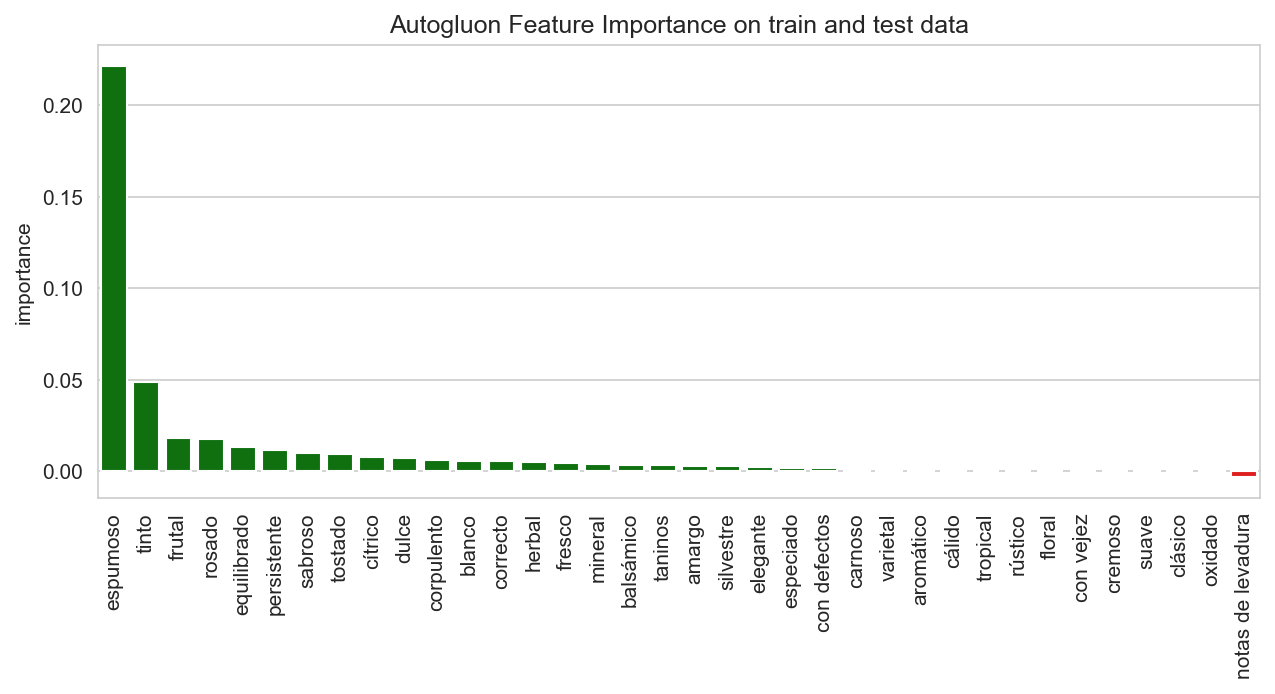

In [170]:
plt.figure(figsize=(10,4),dpi=150);
colors = ['g' if c >= 0 else 'r' for c in ft_importance.importance]

sns.barplot(x=ft_importance.index,y="importance",data=ft_importance, palette=colors)
plt.xticks(rotation=90)
plt.title("Autogluon Feature Importance on train and test data");

### Comparing Autogluon with best grid

In order to choose a proper $k$ (number of different DO we recommend), Random Forest  and AutogluonTabular models are compared

In [86]:
auto_predictor_w =[0.3907408128482797,0.5035687321533677,0.5936792891689876,0.6420309606931951,0.683777972318052 ]
auto_predictor_p =[0.5382585751978892,0.6543535620052771,0.741424802110818,0.783641160949868,0.820580474934037 ]
n_recommendations =[1, 2, 3, 4, 5]

In [87]:
from sklearn.metrics import top_k_accuracy_score
random_forest_w = []
for i in range(5):
    i+=1
    random_forest_w.append(top_k_accuracy_score(y_test.idxmax(axis=1),best_grid.predict_proba(X_test),k=i,sample_weight=y_test_sqrt))

random_forest_p = []
for i in range(5):
    i+=1
    random_forest_p.append(top_k_accuracy_score(y_test.idxmax(axis=1),best_grid.predict_proba(X_test),k=i,))

print(random_forest_w)
print(random_forest_p)

[0.3711812462028979, 0.5023059357452153, 0.5853823741047285, 0.6581878314419599, 0.7461856502702073]
[0.5118733509234829, 0.6385224274406333, 0.712401055408971, 0.7783641160949868, 0.8311345646437994]


In [96]:
recommendators_accuracy = {
    "nRecommendations":n_recommendations * 4,
    "Accuracy": auto_predictor_w + auto_predictor_p + random_forest_w + random_forest_p,
    "Classifier":["AutogluonTabular"] * 10 + ["RandomForest"] * 10, 
    "Accuracy Type":["Weighted","Weighted","Weighted","Weighted","Weighted","Plain","Plain","Plain","Plain","Plain"] * 2

}
recommendators_accuracy = pd.DataFrame(recommendators_accuracy)
#recommendators_accuracy

Text(0.5, 1.0, 'Recommender accuracy vs number of possible recommendations')

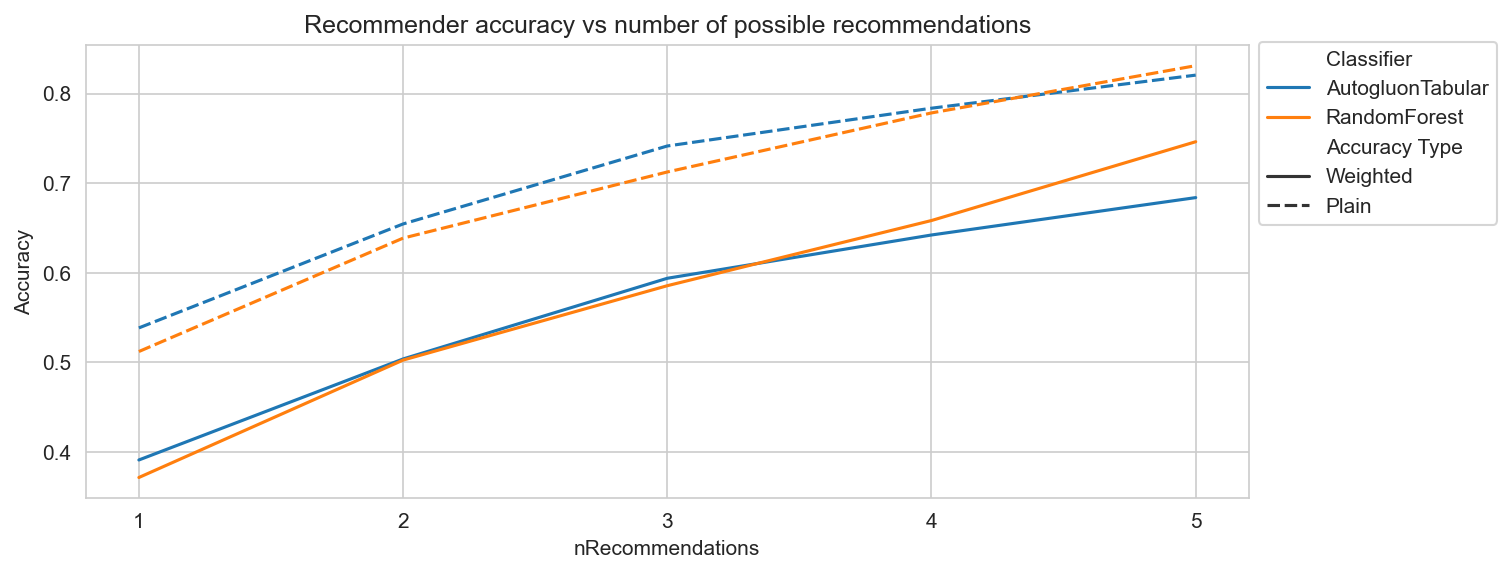

In [116]:
plt.figure(figsize=(10,4),dpi=150);
sns.lineplot(data=recommendators_accuracy, x="nRecommendations", y="Accuracy", hue="Classifier", style="Accuracy Type")
plt.legend(bbox_to_anchor=(1, 1.03), loc="upper left")
plt.xticks(n_recommendations);
plt.title("Recommender accuracy vs number of possible recommendations")

### Select $k=3$

If we plot the confusion matrix for $k=3$

In [138]:
predictions["y_pred"] =  np.where(predictions.correct==True,predictions.label,predictions[0])

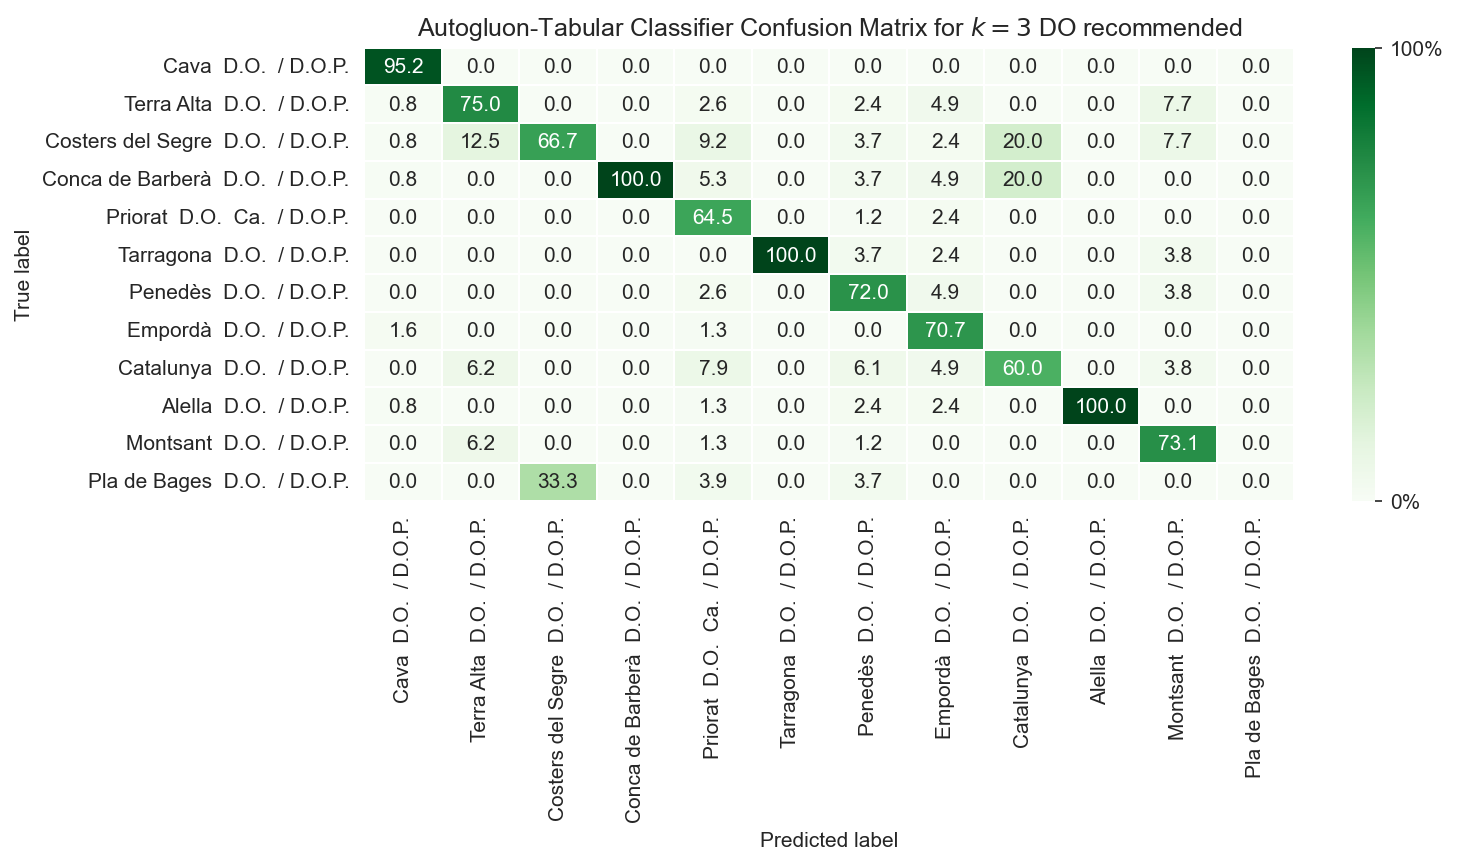

In [140]:
plt.figure(figsize=(10,4),dpi=150);
cm = confusion_matrix(predictions.label, predictions["y_pred"],labels=y_test.columns,normalize="pred") * 100
sns.heatmap(cm, annot=True, fmt='.1f',annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2,vmin=0,vmax=100,cbar_kws={'format': '%.f%%', 'ticks': [0, 100]},)

tick_marks = np.arange(len(y_test.columns)) +.5
plt.xticks(tick_marks,y_test.columns,rotation=90)
plt.yticks(tick_marks,y_test.columns,rotation=0)

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title("Autogluon-Tabular Classifier Confusion Matrix for $k=3$ DO recommended");

### Using new class

In [62]:
from predictDO import multiple_autogluonClassifier
predictor = multiple_autogluonClassifier(r"AutogluonModels/ag-20220820_164753/")

In [63]:
styles_vector = ['blanco',"herbal"]

predictor.predict_do(styles_vector)

OrderedDict([('Penedès  D.O.  / D.O.P.', 0.82086181640625),
             ('Empordà  D.O.  / D.O.P.', 0.15526442229747772),
             ('Alella  D.O.  / D.O.P.', 0.0188533253967762),
             ('Montsant  D.O.  / D.O.P.', 0.002425412880256772),
             ('Terra Alta  D.O.  / D.O.P.', 0.0015061558224260807),
             ('Pla de Bages  D.O.  / D.O.P.', 0.0006036463310010731),
             ('Priorat  D.O.  Ca.  / D.O.P.', 0.0002259969332953915),
             ('Tarragona  D.O.  / D.O.P.', 8.255363354692236e-05),
             ('Catalunya  D.O.  / D.O.P.', 7.585457933600992e-05),
             ('Conca de Barberà  D.O.  / D.O.P.', 5.717569001717493e-05),
             ('Costers del Segre  D.O.  / D.O.P.', 3.3030417398549616e-05),
             ('Cava  D.O.  / D.O.P.', 1.0631713848852087e-05)])

In [65]:
styles_vector = ['tinto',"calido"]

predictor.predict_do(styles_vector)

OrderedDict([('Penedès  D.O.  / D.O.P.', 0.8146668076515198),
             ('Empordà  D.O.  / D.O.P.', 0.10132373124361038),
             ('Priorat  D.O.  Ca.  / D.O.P.', 0.051690246909856796),
             ('Montsant  D.O.  / D.O.P.', 0.0238825511187315),
             ('Conca de Barberà  D.O.  / D.O.P.', 0.005396753083914518),
             ('Costers del Segre  D.O.  / D.O.P.', 0.0010498649207875133),
             ('Terra Alta  D.O.  / D.O.P.', 0.0007033158326521516),
             ('Tarragona  D.O.  / D.O.P.', 0.0004995615454390645),
             ('Catalunya  D.O.  / D.O.P.', 0.00033596905996091664),
             ('Pla de Bages  D.O.  / D.O.P.', 0.0002474897191859782),
             ('Alella  D.O.  / D.O.P.', 0.00018120459571946412),
             ('Cava  D.O.  / D.O.P.', 2.2483965949504636e-05)])

In [14]:
styles_vector = ['tinto','herbal']

predictor.predict_do(styles_vector)

OrderedDict([('Penedès  D.O.  / D.O.P.', 0.9204674959182739),
             ('Empordà  D.O.  / D.O.P.', 0.0733872726559639),
             ('Montsant  D.O.  / D.O.P.', 0.002505833748728037),
             ('Priorat  D.O.  Ca.  / D.O.P.', 0.002395408460870385),
             ('Catalunya  D.O.  / D.O.P.', 0.0003465724003035575),
             ('Pla de Bages  D.O.  / D.O.P.', 0.00026210470241494477),
             ('Tarragona  D.O.  / D.O.P.', 0.0002247890952276066),
             ('Conca de Barberà  D.O.  / D.O.P.', 0.0002015411591855809),
             ('Terra Alta  D.O.  / D.O.P.', 0.00011458864901214838),
             ('Costers del Segre  D.O.  / D.O.P.', 6.480859155999497e-05),
             ('Alella  D.O.  / D.O.P.', 2.0845378458034247e-05),
             ('Cava  D.O.  / D.O.P.', 8.791545951680746e-06)])

In [13]:
styles_vector = ['tinto', 'maduro','persistente']
predictor.predict_do(styles_vector)

OrderedDict([('Priorat  D.O.  Ca.  / D.O.P.', 0.7791297435760498),
             ('Penedès  D.O.  / D.O.P.', 0.1368532031774521),
             ('Empordà  D.O.  / D.O.P.', 0.03703552111983299),
             ('Costers del Segre  D.O.  / D.O.P.', 0.014668868854641914),
             ('Montsant  D.O.  / D.O.P.', 0.01458362489938736),
             ('Conca de Barberà  D.O.  / D.O.P.', 0.010860810056328773),
             ('Pla de Bages  D.O.  / D.O.P.', 0.003667450975626707),
             ('Catalunya  D.O.  / D.O.P.', 0.0015600009355694056),
             ('Terra Alta  D.O.  / D.O.P.', 0.0013134039472788572),
             ('Alella  D.O.  / D.O.P.', 0.0002218675654148683),
             ('Tarragona  D.O.  / D.O.P.', 9.799971303436905e-05),
             ('Cava  D.O.  / D.O.P.', 7.538390946137952e-06)])

## NN architecture

In [160]:
def NN_get_sqrt_score(y_true,model,X_train,weights_dict=sqrt_weight):
    prediction = model.predict(X_train)
    max_prediction = prediction.argmax(axis=1)

    y_pred = []
    for pred in max_prediction:
        y_pred.append(y_train.columns[pred])
    y_pred_val = np.asarray(y_pred)
    return accuracy_score(y_true.idxmax(axis=1),y_pred_val,sample_weight=np.vectorize(weights_dict.get)((y_true.values.argmax(axis=1))))

In [161]:
model = Sequential()
model.add(Dense(20, input_dim=X.shape[1], activation='relu'))
#model.add(Dense(20, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(y.shape[1], activation='softmax'))
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 20)                740       
_________________________________________________________________
dense_32 (Dense)             (None, 15)                315       
_________________________________________________________________
dense_33 (Dense)             (None, 12)                192       
Total params: 1,247
Trainable params: 1,247
Non-trainable params: 0
_________________________________________________________________


In [162]:
# Calculate the class weights
class_weights={}
for i,do in enumerate(y_train.columns):
    class_weights[i]= y_count[y_count.DO==do].SQRTbalanced_weight.values[0]

#class_weights

In [163]:
# Binary cross-entropy is for multi-label classifications, whereas categorical cross entropy is for multi-class classification where each example belongs to a single class
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [164]:
es = EarlyStopping(monitor="val_loss", patience=15, verbose=1, mode="min",restore_best_weights=True)
history = model.fit(X_train,y_train, epochs=50,batch_size=32,validation_split=.3,class_weight=class_weights,callbacks=[es,])

Epoch 1/50
47/47 [==============================] - 1s 7ms/step - loss: 4.1920 - accuracy: 0.2863 - val_loss: 2.3470 - val_accuracy: 0.3473
Epoch 2/50
47/47 [==============================] - 0s 5ms/step - loss: 4.0808 - accuracy: 0.3628 - val_loss: 2.2177 - val_accuracy: 0.3845
Epoch 3/50
47/47 [==============================] - 0s 5ms/step - loss: 3.9627 - accuracy: 0.3815 - val_loss: 2.0750 - val_accuracy: 0.3953
Epoch 4/50
47/47 [==============================] - 0s 5ms/step - loss: 3.8299 - accuracy: 0.3955 - val_loss: 1.9193 - val_accuracy: 0.4233
Epoch 5/50
47/47 [==============================] - 0s 5ms/step - loss: 3.6993 - accuracy: 0.4101 - val_loss: 1.8160 - val_accuracy: 0.4388
Epoch 6/50
47/47 [==============================] - 0s 5ms/step - loss: 3.5921 - accuracy: 0.4414 - val_loss: 1.7471 - val_accuracy: 0.4605
Epoch 7/50
47/47 [==============================] - 0s 5ms/step - loss: 3.5129 - accuracy: 0.4514 - val_loss: 1.7029 - val_accuracy: 0.4481
Epoch 8/50
47/47 [==

In [165]:
NN_get_sqrt_score(y_train,model,X_train,weights_dict=sqrt_weight)

0.36988236823278975

In [ ]:
NN_get_sqrt_score(y_test,model,X_test,weights_dict=sqrt_weight)

0.35449963935688983